In [93]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.utils.data as data
from PIL import Image
import torch.nn.functional as F

In [4]:
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"GPU is available with {num_gpus} device(s).")
    
    # Get the name of the current GPU
    current_gpu = torch.cuda.get_device_name(0)  # Assuming the first GPU is used
    print(f"Current GPU: {current_gpu}")
else:
    print("GPU is not available. Using CPU.")

GPU is not available. Using CPU.


In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the first available GPU
else:
    device = torch.device("cpu")  # If no GPU is available, use CPU

In [72]:
current_directory = os.getcwd()
models_dir = current_directory + '/models'
os.makedirs(models_dir, exist_ok=True)
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [123]:
class SolarPanelDataset(data.Dataset):
    def __init__(self, df, data_dir, image_shape=(3, 256, 256), augmentation_copies=3):
        self.copies = 1+augmentation_copies
        self.image_shape = image_shape
        self.df = df
        self.labels = []
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])
        self.augmentation_transform = self.make_augmentation_transform()
        self.dataset_size = len(df)
        self.images = torch.zeros((self.dataset_size, *self.image_shape), dtype=torch.float32)
        for i, img_name in enumerate(self.df['original_title']):
            img_path = os.path.join(data_dir, img_name)
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            self.images[i] = image
            label = df.iloc[i]['loss_percentage']
            self.labels.append(label)  # Add corresponding label here

    def __len__(self):
        return len(self.images)*self.copies

    def make_augmentation_transform(self):
        return transforms.Compose([
            transforms.RandomResizedCrop((self.image_shape[1], self.image_shape[2])),
            transforms.RandomHorizontalFlip(p=0.2),
            transforms.RandomVerticalFlip(p=0.2),
            transforms.RandomRotation(45),
            transforms.ColorJitter(brightness=(0.3, 2), contrast=0, saturation=0, hue=0),
            #transforms.RandomGrayscale(p=0.1)
        ])
        
    def __getitem__(self, idx):
        if (idx >= len(self.images) ):
            image = self.images[idx % len(self.images)]
            label = self.labels[idx % len(self.labels)]
            return self.augmentation_transform(image), torch.tensor(label, dtype=torch.float32)
            
            
        image = self.images[idx]
        label = self.labels[idx]
        return image, torch.tensor(label, dtype=torch.float32)

In [124]:
class ProfessorsCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(59536, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [127]:

# Function to save the model
def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          num_epochs,
          path_model,
          verbatim):
    model.train()
    model.to(device)
    best_accuracy = 0.0
    best_loss = 0.0
    best_epoch = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        train_acc = 0.0
        train_loss = 0.0
        for ibatch, (images, labels) in enumerate(dataloader, 0):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            y_pred = model(images)
            y_pred = y_pred.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            loss = loss_fn(y_pred, labels)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            # 3. Optimizer zero grad
            # ...

            # 4. Loss backward
            # ...

            # 5. Optimizer step
            optimizer.step()

            print(loss)
            # Calculate and accumulate accuracy metric across all batches
            #y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            #train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

        print(train_loss)
        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss / len(dataloader)
        #train_acc = train_acc / len(dataloader)

        # we want to save the model if the accuracy is the best

        path = "./myModel_" +str(epoch)+ ".pth"
        saveModel(model, path = path)


        #if train_acc > best_accuracy:
        #    path = str(path_model)
        #    saveModel(model, path = path)
        #    best_loss = train_loss
        #    best_accuracy = train_acc
        #    best_epoch = epoch
        #    if verbatim:
        #      print('Best Epoch #', epoch,' Loss=', best_loss, " Accu=", best_accuracy )

    return best_loss, best_accuracy, best_epoch 

In [128]:
model = ProfessorsCNN()
dataset = SolarPanelDataset(train_df.sample(200), '/home/victor/mestrado/cv/project/CV-Project/SolarPanelSoilingImageDataset/Solar_Panel_Soiling_Image_dataset/PanelImages/')
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
loss_fn = torch.nn.MSELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
num_epochs = 10
path_model = models_dir + f'/{model.__class__.__name__}_{loss_fn.__class__.__name__}'
os.makedirs(path_model, exist_ok=True)
train(model, train_dataloader, loss_fn, optimizer, device, num_epochs, path_model, verbatim=True)

tensor(0.1181, grad_fn=<MseLossBackward0>)
tensor(0.0806, grad_fn=<MseLossBackward0>)
tensor(0.0682, grad_fn=<MseLossBackward0>)
tensor(0.1052, grad_fn=<MseLossBackward0>)
tensor(0.0702, grad_fn=<MseLossBackward0>)
tensor(0.0865, grad_fn=<MseLossBackward0>)
tensor(0.0499, grad_fn=<MseLossBackward0>)
tensor(0.1023, grad_fn=<MseLossBackward0>)
tensor(0.0942, grad_fn=<MseLossBackward0>)
tensor(0.0755, grad_fn=<MseLossBackward0>)
tensor(0.0793, grad_fn=<MseLossBackward0>)
tensor(0.0878, grad_fn=<MseLossBackward0>)
tensor(0.0841, grad_fn=<MseLossBackward0>)
tensor(0.0983, grad_fn=<MseLossBackward0>)
tensor(0.0706, grad_fn=<MseLossBackward0>)
tensor(0.0835, grad_fn=<MseLossBackward0>)
tensor(0.0929, grad_fn=<MseLossBackward0>)
tensor(0.1033, grad_fn=<MseLossBackward0>)
tensor(0.0881, grad_fn=<MseLossBackward0>)
tensor(0.0942, grad_fn=<MseLossBackward0>)
tensor(0.0722, grad_fn=<MseLossBackward0>)
tensor(0.0722, grad_fn=<MseLossBackward0>)
tensor(0.0561, grad_fn=<MseLossBackward0>)
tensor(0.06

KeyboardInterrupt: 

In [115]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 3, 3, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Encode the input image
        encoded = self.encoder(x)

        # Reconstruct the original image from the compressed representation
        reconstructed = self.decoder(encoded)

        return reconstructed

In [116]:
autoencoder = Autoencoder()
autoencoder = autoencoder.to(device)

In [117]:
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [118]:
autoencoder.train()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Sigmoid()
  )
)

In [120]:
for epoch in range(1):
    for i, images in enumerate(train_dataloader):

        images = images.to(device)
        # Reconstruct the images
        reconstructions = autoencoder(images)

        # Calculate the loss
        loss = loss_function(reconstructions, images)

        print('aaa')
        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('bbb')

        # Print the loss
        if i % 100 == 0:
            print('Epoch: {}/10, Iteration: {}/{} Loss: {}'.format(epoch, i, len(train_dataloader), loss.item()))

aaa
bbb
Epoch: 0/10, Iteration: 0/96 Loss: 1.028418046189472e-05
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb
aaa
bbb


In [29]:
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [30]:
autoencoder.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Sigmoid()
  )
)

In [31]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [32]:
for test_batch, _ in test_dataloader:
    test_batch = test_batch.to(device)
    predicted_image_batch = autoencoder(test_batch)
    encoded_batch = autoencoder.encoder(test_batch)
    break

In [33]:

def tensor_to_image(tensor):

    """
    Converts a tensor to an image.

    Args:
        tensor: A tensor of shape (C, H, W).

    Returns:
        An image.
    """

    image = tensor.cpu().detach().numpy()
    image = image.transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    image = (image * 255).astype('uint8')  # Convert pixel values from [0, 1] to [0, 255]

    return image


In [34]:
predicted_image_batch[0].size()

torch.Size([3, 32, 32])

In [35]:
torch.mean(encoded_batch[2].transpose(0, 1).transpose(0,2),dim=1).unsqueeze(0).size()

torch.Size([1, 16, 16])

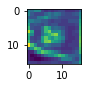

In [36]:
plt.figure(figsize=(1, 1))
plt.imshow(tensor_to_image(torch.mean(encoded_batch[5].transpose(0, 1).transpose(0,2),dim=1).unsqueeze(0)))
plt.show()

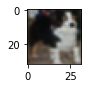

In [42]:
plt.figure(figsize=(1, 1))
plt.imshow(tensor_to_image(predicted_image_batch[3]))
plt.show()

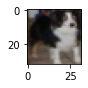

In [41]:
plt.figure(figsize=(1, 1))
plt.imshow(tensor_to_image(test_batch[3]))
plt.show()